In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
print(tf.__version__)

1.12.0


# Loading the Boston housing dataset

In [18]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

# Data analysis

In [19]:
x = train_data
print("Training Data:", len(x.shape), 'D Tensor,', x.shape[0], 'samples, with',x.shape[1],'features,', x.dtype, 'data type.')
x = train_targets
print("Training Targets:", len(x.shape), 'D Tensor,', x.shape[0], x.dtype, 'data type.')
x = test_data
print("Test Data:", len(x.shape), 'D Tensor,', x.shape[0], 'samples with',x.shape[1],'features,', x.dtype, 'data type.')
x = test_targets
print("Test Targets:", len(x.shape), 'D Tensor,', x.shape[0], 'samples,', x.dtype, 'data type.')

Training Data: 2 D Tensor, 404 samples, with 13 features, float64 data type.
Training Targets: 1 D Tensor, 404 float64 data type.
Test Data: 2 D Tensor, 102 samples with 13 features, float64 data type.
Test Targets: 1 D Tensor, 102 samples, float64 data type.


In [20]:
print(train_data[0])

[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]


In [23]:
# house price in K$
print(train_targets[:10])

[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4]


- The 13 features in the input data are as follow:
1. Per capita crime rate.
2. Proportion of residential land zoned for lots over 25,000 square feet.
3. Proportion of non-retail business acres per town.
4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5. Nitric oxides concentration (parts per 10 million).
6. Average number of rooms per dwelling.
7. Proportion of owner-occupied units built prior to 1940.
8. Weighted distances to five Boston employment centres.
9. Index of accessibility to radial highways.
10. Full-value property-tax rate per $10,000.
11. Pupil-teacher ratio by town.
12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
13. % lower status of the population.

In [22]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
               'TAX', 'PTRATIO', 'B', 'LSTAT']

df = pd.DataFrame(train_data, columns=column_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65


# Preparing the data

- Feature-wise normalization: for each feature in the input data (a column in the input data matrix), you subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation.
- https://towardsdatascience.com/the-surprising-longevity-of-the-z-score-a8d4f65f64a0 
- The Standard Deviation is a measure of how spread out numbers are:
    - Step 1: Find the mean.
    - Step 2: For each data point, find the square of its distance to the mean.
    - Step 3: Sum the values from Step 2.
    - Step 4: Divide by the number of data points.
    - Step 5: Take the square root.
- Quantities used for normalizing the test data are computed using the training data. You should never use in your workflow any quantity computed on the test data, even for something as simple as data normalization.


In [24]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

print(train_data[0])

[-0.27224633 -0.48361547 -0.43576161 -0.25683275 -0.1652266  -0.1764426
  0.81306188  0.1166983  -0.62624905 -0.59517003  1.14850044  0.44807713
  0.8252202 ]


# Model definition

- In general, the less training data you have, the worse overfitting will be, and using a small network is one way to mitigate overfitting.
- The network ends with a single unit and no activation (it will be a linear layer). This is a typical setup for scalar regression (a regression where you’re trying to predict a single continuous value). Applying an activation function would constrain the range the output can take; for instance, if you applied a sigmoid activation function to the last layer, the network could only learn to predict values between 0 and 1. Here, because the last layer is purely linear, the network is free to learn to predict values in any range.
- mse loss function—mean squared error, the square of the difference between the predictions and the targets. This is a widely used loss function for regression problems.
- metric during training: mean absolute error (MAE). It’s the absolute value of the difference between the predictions and the targets.
- https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d
- For instance, an MAE of 0.5 on this problem would mean your predictions are off by $500 on average <= 1k(house unit price)*0.5.

In [7]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation=tf.nn.relu,
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation=tf.nn.relu))
    model.add(layers.Dense(1))
    model.compile(optimizer=optimizers.RMSprop(lr=0.001),
                  loss=losses.mse,
                  metrics=[metrics.mae])
    return model

# Build, Train and K-fold Validation

- Splitting the available data into K partitions (typically K = 4 or 5), instantiating K identical models, and training each one on K – 1 partitions while evaluating on the remaining partition. The validation score for the model used is then the average of the K validation scores obtained.
- https://medium.com/datadriveninvestor/k-fold-cross-validation-6b8518070833

In [8]:
k = 4
num_val_samples = len(train_data) // 4
num_epochs = 100
all_mae_histories = []
all_scores = []
for i in range(k):
    print('processing fold #', i) 
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                        train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                        train_targets[(i + 1) * num_val_samples:]], axis=0)
    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data = (val_data, val_targets),
                        epochs=num_epochs, batch_size=1,  verbose=0)
 
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    
print(model.summary())  
# Training logs
history_dict = history.history
print(history_dict.keys())


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________
None
dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


In [9]:
# compute the average of the per-epoch MAE scores for all folds
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

# Plotting validation scores

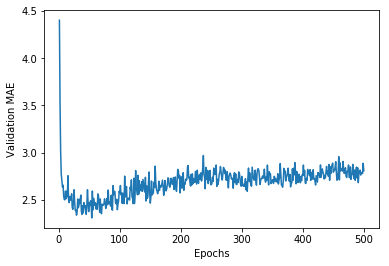

In [10]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

- Omit the first 10 data points, which are on a different scale than the rest of the curve.
- Replace each point with an exponential moving average of the previous points, to obtain a smooth curve

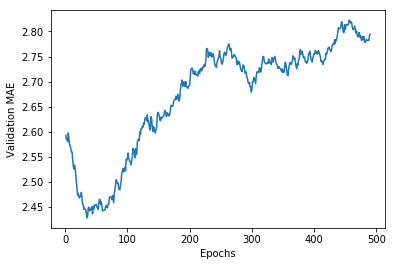

In [11]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# Training the final model

In [12]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 725us/step


In [13]:
test_mae_score

2.5524150997984645

- off by about $2,550.